In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

Epoch 0, Loss: 7359600.470238
Epoch 10, Loss: 4840189.533234
Epoch 20, Loss: 2075932.653646
Epoch 30, Loss: 2450895.936260
Epoch 40, Loss: 1888384.854911
Epoch 50, Loss: 1061310.277778
Epoch 60, Loss: 1011855.536582
Epoch 70, Loss: 633494.750806
Epoch 80, Loss: 840797.175719
Epoch 90, Loss: 545138.384611
Epoch 100, Loss: 1579492.507254
Epoch 110, Loss: 1139717.025918
Epoch 120, Loss: 848318.160342
Epoch 130, Loss: 345951.451389
Epoch 140, Loss: 166943.655320
Epoch 150, Loss: 434460.221912
Epoch 160, Loss: 1208412.454799
Epoch 170, Loss: 871271.576575
Epoch 180, Loss: 649138.457217
Epoch 190, Loss: 252045.139757
Epoch 200, Loss: 381800.958457
Epoch 210, Loss: 179168.118614
Epoch 220, Loss: 162896.239769
Epoch 230, Loss: 208921.967014
Epoch 240, Loss: 1937542.220858
Epoch 250, Loss: 1433677.719928
Epoch 260, Loss: 228491.413938
Epoch 270, Loss: 119888.714038
Epoch 280, Loss: 395295.919209
Epoch 290, Loss: 163950.237754
Epoch 300, Loss: 129130.357825
Epoch 310, Loss: 260180.626550
Epoch 3

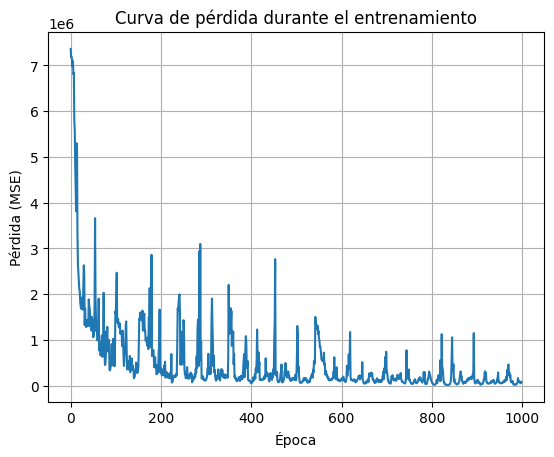

In [ ]:
# =========================
# Dataset personalizado
# =========================

class PlacaDataset(Dataset):
    def __init__(self, X_path, Y_path):
        
        self.X = np.load(X_path).astype(np.float32)
        self.Y = np.load(Y_path).astype(np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# =========================
# Definición del modelo
# =========================
class MLPTempRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# =========================
# Configuración
# =========================
X_path = 'C:/Users/royer/Documents/ProyectoFinalModelado/data/dataset_1000_test/X.npy'
Y_path = 'C:/Users/royer/Documents/ProyectoFinalModelado/data/dataset_1000_test/Y.npy'

dataset = PlacaDataset(X_path, Y_path)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

input_dim = dataset.X.shape[1]
output_dim = dataset.Y.shape[1]

model = MLPTempRegressor(input_dim, output_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000

# =========================
# Entrenamiento
# =========================
loss_history = []

for epoch in range(epochs):
    running_loss = 0.0
    for X_batch, Y_batch in dataloader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    loss_history.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

print("✅ Entrenamiento finalizado.")



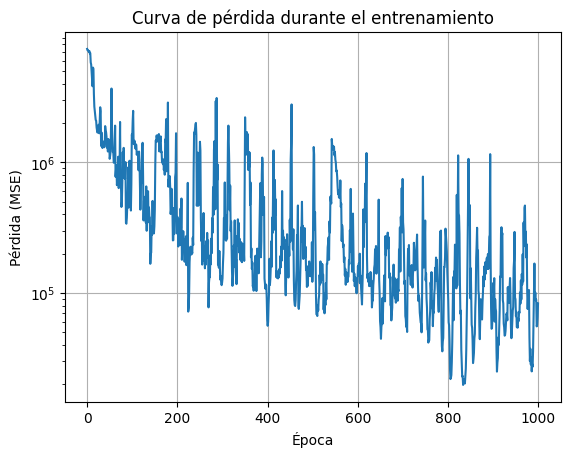

[7359600.470238095, 7178822.470238095, 7187364.596230159, 7116146.305927579, 6969054.575272817, 7093256.447668651, 6805186.151661706, 6836712.344618056, 5799407.686011905, 5586712.451140873, 4840189.533234127, 4294712.772569444, 3812945.5070684524, 5297845.448784722, 5183393.500868056, 3325129.066840278, 2663630.615327381, 2469011.0007440476, 2273999.279265873, 2106483.863839286, 2075932.6536458333, 1846016.5572916667, 1743879.1475694445, 1684172.318080357, 1750589.5028521826, 1916044.291170635, 1937531.572420635, 1663364.5388144841, 2121042.451636905, 2633264.175843254, 2450895.9362599207, 1331234.5102926588, 1686804.2570684524, 1327637.2134176588, 1283987.0554315476, 1375470.9918154762, 1439001.8666914683, 1343287.693700397, 1301082.396453373, 1334419.8583829366, 1888384.8549107143, 1749716.884920635, 1700311.3874007936, 1570579.156374008, 1291331.6650545634, 1434310.535218254, 1207559.081845238, 1504200.5637400793, 1319569.941344246, 1426745.4051339286, 1061310.2777777778, 1121962.1

In [41]:
# =========================
# Visualización de la pérdida
# =========================
plt.figure()
plt.semilogy(loss_history)
plt.xlabel("Época")
plt.ylabel("Pérdida (MSE)")
plt.title("Curva de pérdida durante el entrenamiento")
plt.grid()
plt.show()
print(loss_history)


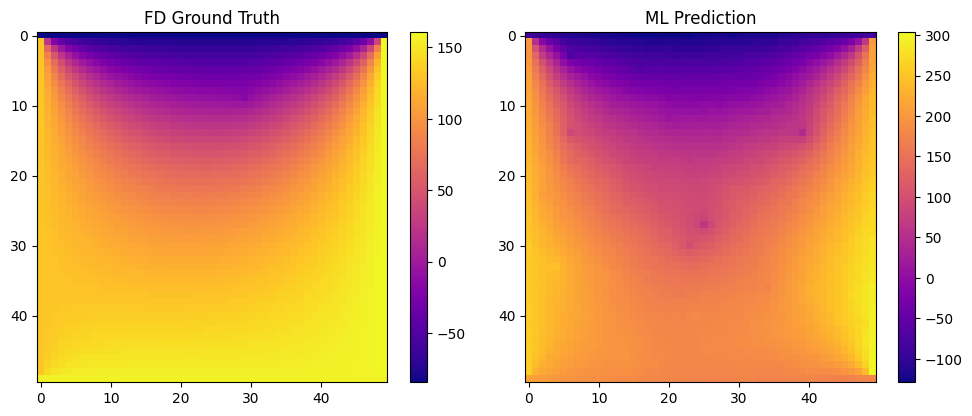

In [35]:
# =========================
# Evaluación de resultados
# =========================
# Seleccionar una muestra para visualizar
X_sample, Y_true = dataset[589]
X_sample_tensor = torch.tensor(X_sample).unsqueeze(0).to(device)

Y_pred = model(X_sample_tensor).detach().cpu().numpy().reshape(50, 50)  # Ajustar según Nx, Ny

Y_true_reshaped = Y_true.reshape(50, 50)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("FD Ground Truth")
plt.imshow(Y_true_reshaped, cmap='plasma')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("ML Prediction")
plt.imshow(Y_pred, cmap='plasma')
plt.colorbar()

plt.tight_layout()
plt.show()

In [42]:
# =========================
# Guardar modelo entrenado
# =========================
model_save_path = 'C:/Users/royer/Documents/ProyectoFinalModelado/results/modelo_temp_ML2.pt'
torch.save(model.state_dict(), model_save_path)
print(f"✅ Modelo guardado en: {model_save_path}")

✅ Modelo guardado en: C:/Users/royer/Documents/ProyectoFinalModelado/results/modelo_temp_ML2.pt
